# Identify Fraud from Enrom Email

## Background and the Problem

The [Enron scandal](https://en.wikipedia.org/wiki/Enron_scandal) is one of the biggest corruption episodes in the United States of American history. Enrom's senior executives such as [Jeffrey Skilling](https://en.wikipedia.org/wiki/Jeffrey_Skilling) and [Kennet Lay](https://en.wikipedia.org/wiki/Kenneth_Lay) were systematically involved in illegal schemes aiming to greedly improve profits and power over different sectors in the North American society. These illicit acts ultimately led to the bankrupcy of the [Enrom Corporation](https://en.wikipedia.org/wiki/Enron) in October 2001.

In this script we will explore a Enrom dataset containing financial and email employees' data and try to come up with a machine learning model able to efficiently classify the former Enrom's employees as a Person of Interest (POI) probably envolved in the corruption mechanism. We will try different classification models, checking their perfomances, and, optimizing their hyperparameters. 

## Libraries and Initizalization

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from scipy.stats import randint as sp_randint
from scipy.stats import expon

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn import tree
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester  import dump_classifier_and_data

%matplotlib inline

# Seaborn settings
rc_axes = {
    "axes.edgecolor": "#CFCFCF",
    "axes.facecolor": ".97",
    "grid.color": "#CFCFCF",
    "axes.linewidth": 1.5
}
sns.set_palette("Set2")
sns.set_style("darkgrid", rc_axes)

rc_fig = {
    "axes.titlesize":14.0,
    "axes.labelsize": 13.0,
    "xtick.labelsize": 12.0,
    "ytick.labelsize": 12.0,
}
sns.set_context(rc=rc_fig)

/Users/diogocosin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Exploratory Data Analysis

The Enrom Dataset presents financial and e-mail data of former Enrom's employees. Let's take a look at it.

### Loading the Data

In [2]:
train = pd.read_pickle("final_project_dataset.pkl")
df_train = pd.DataFrame.from_dict(train, orient="index")

In [3]:
df_train.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


The data has some NaNs. Let's check them type.

In [4]:
type(df_train.loc["BADUM JAMES P"]["salary"])

str

The NaN is actually a string already embedded in the raw dataset. Just for the sake of convention, let's replace all "NaN" strings with numpy nan.

In [5]:
df_train = df_train.replace("NaN", np.nan)
type(df_train.loc["BADUM JAMES P"]["salary"])

numpy.float64

### Data Structure

In [6]:
df_train.shape

(146, 21)

The dataset possess 21 features of 146 observations. Let's take a look at the 21 features.

In [7]:
df_train.columns.values

array(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'exercised_stock_options', 'bonus', 'restricted_stock',
       'shared_receipt_with_poi', 'restricted_stock_deferred',
       'total_stock_value', 'expenses', 'loan_advances', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'director_fees',
       'deferred_income', 'long_term_incentive', 'email_address',
       'from_poi_to_this_person'], dtype=object)

Among the 21 features, we can see the target feature "poi". Next, let's take an intial look at it. 

### Target Feature Balance

We expect the "poi"feature to be unbalanced given that, supposedly, there are not many corrupt employees. A countplot is able to confirm this speculation.

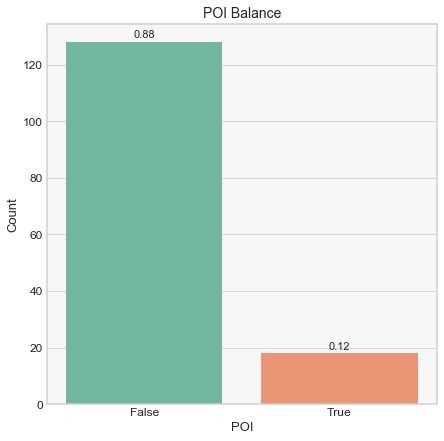

In [8]:
plt.figure(figsize=(7,7))
ax = sns.countplot(x="poi", data=df_train)
total = len(df_train)
ax.set_title("POI Balance")
ax.set_xlabel("POI")
ax.set_ylabel("Count")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1.5,
            '{:1.2f}'.format(height/total),
            ha="center", fontsize=11)


The dataset target feature, POI, as expected, is pretty unbalaced. Only 12% out of 146 Enrom's employees are POIs. This dataset's characteristic is important because it will affect in the choice of the classification models evaluation metrics.

### Checking for Outliers

In order to check for outliers, let's visualize the relationship between the "salary" and "poi" features.

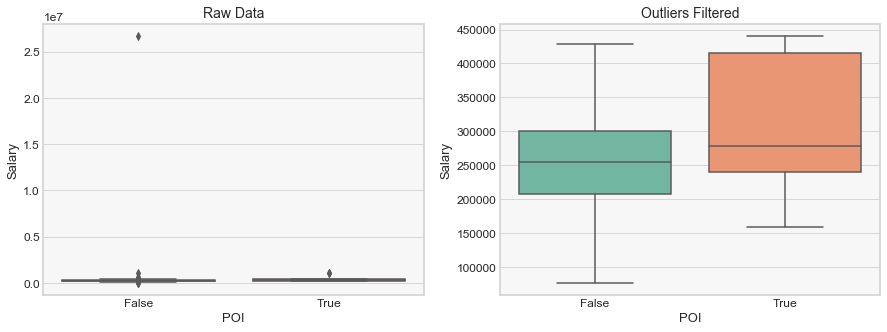

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
ax1 = sns.boxplot(x="poi", y="salary", data=df_train, ax=axs[0])
ax2 = sns.boxplot(x="poi", y="salary", data=df_train, showfliers=False, ax=axs[1])
ax1.set_title("Raw Data"); ax1.set_xlabel("POI"); ax1.set_ylabel("Salary");
ax2.set_title("Outliers Filtered"); ax2.set_xlabel("POI"); ax2.set_ylabel("Salary");

Clearly, there is an outlier in the data. Let's take a closer look at it.

In [10]:
df_train_srt = df_train.sort_values(by="salary", ascending=False)
df_train_srt.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
TOTAL,26704229.0,NaN,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,NaN,-7576788.0,434509511.0,...,83925000.0,NaN,42667589.0,NaN,False,1398517.0,-27992891.0,48521928.0,NaN,NaN
SKILLING JEFFREY K,1111258.0,3627.0,NaN,8682716.0,19250000.0,5600000.0,6843672.0,2042.0,NaN,26093672.0,...,NaN,108.0,22122.0,30.0,True,NaN,NaN,1920000.0,jeff.skilling@enron.com,88.0
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,NaN,49110078.0,...,81525000.0,36.0,10359729.0,16.0,True,NaN,-300000.0,3600000.0,kenneth.lay@enron.com,123.0
FREVERT MARK A,1060932.0,3275.0,6426990.0,17252530.0,10433518.0,2000000.0,4188667.0,2979.0,NaN,14622185.0,...,2000000.0,21.0,7427621.0,6.0,False,NaN,-3367011.0,1617011.0,mark.frevert@enron.com,242.0
PICKERING MARK R,655037.0,898.0,NaN,1386690.0,28798.0,300000.0,NaN,728.0,NaN,28798.0,...,400000.0,67.0,NaN,0.0,False,NaN,NaN,NaN,mark.pickering@enron.com,7.0


The outlier is related to an index "TOTAL". This index looks like a sheet feature that sums up all indexes salries. In order to confirm that, let's sum up all the salaries and check if the returned result is consistent with the "TOTAL" salary.

In [11]:
df_train_srt.iloc[1:]["salary"].sum()

26704229.0

The "TOTAL" salary is truly the sum of all salaries available on the dataset. Thus, let's remove this row.

In [12]:
df_train = df_train.drop("TOTAL")

Now that the detected outlier has been removed, let's carry with our Data Exploration focusing on the Multivariate Analysis.

### Missing Values

#### Sparsity Check

We will use the **missingno** library to check possible missing values.

In [13]:
missingValueColumns = df_train.columns[df_train.isnull().any()].tolist()
df_null = df_train[missingValueColumns]

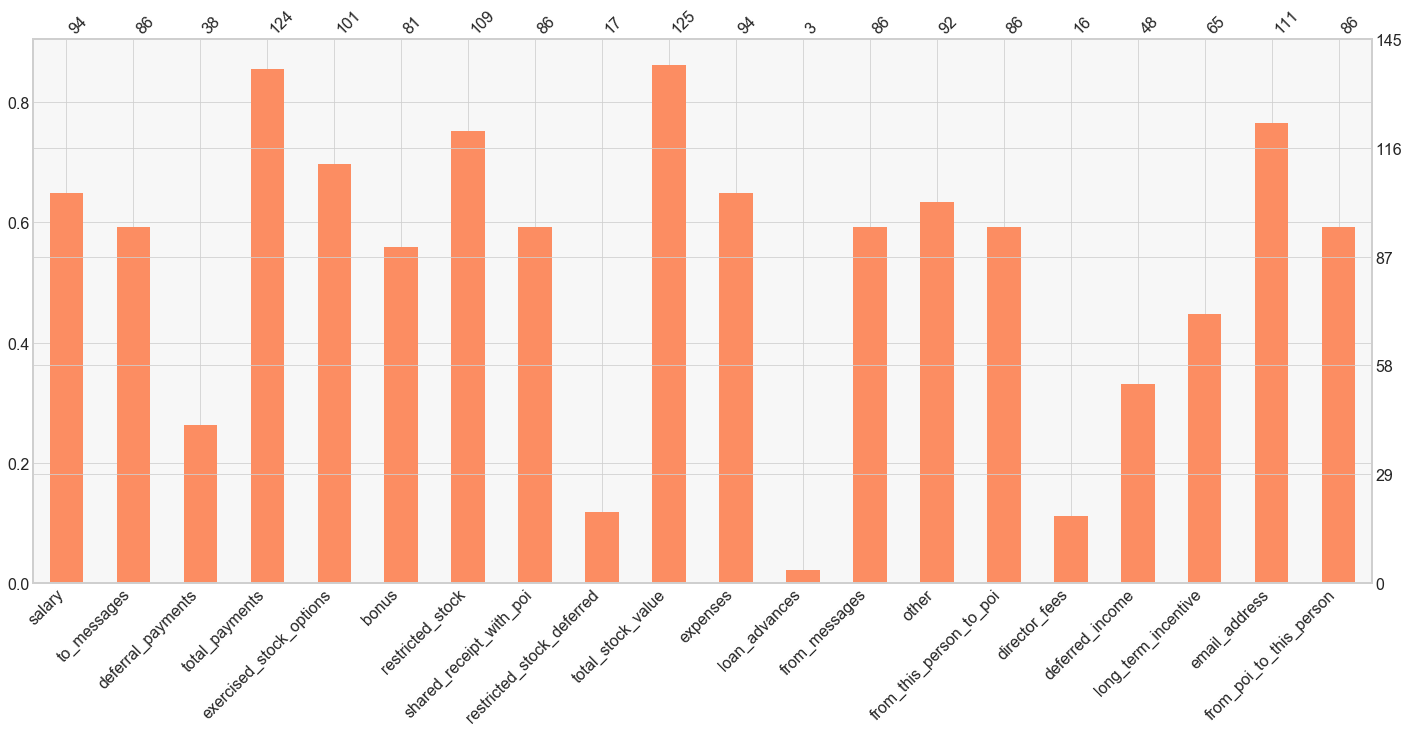

In [14]:
msno.bar(df_null, color='#fc8d62')

The features "loan_advances", "director_fees" are highly sparse. Less than 40% of the observations possess these attributes. Let's take a look at them.

#### Loan Advances

In [15]:
df_train[df_train["loan_advances"].notnull()][["loan_advances", "poi"]]

,loan_advances,poi
FREVERT MARK A,2000000.0,False
LAY KENNETH L,81525000.0,True
PICKERING MARK R,400000.0,False


Only 3 out of the 146 have the "loan_advances" attribue filled.

Considering how sparse this feature is and that it is not possible to draw any pattern from the three observations, let's remove it.

In [16]:
df_train = df_train.drop(["loan_advances"], axis=1)
df_train.shape

(145, 20)

#### Director Fees

In [17]:
df_train[df_train["director_fees"].notnull()][["director_fees", "poi"]]

,director_fees,poi
BELFER ROBERT,3285.0,False
BHATNAGAR SANJAY,137864.0,False
BLAKE JR. NORMAN P,113784.0,False
CHAN RONNIE,98784.0,False
DUNCAN JOHN H,102492.0,False
GRAMM WENDY L,119292.0,False
JAEDICKE ROBERT,108750.0,False
LEMAISTRE CHARLES,112492.0,False
MENDELSOHN JOHN,103750.0,False
MEYER JEROME J,38346.0,False


Due to the same reason given to the "loan_advances" deletion, let's also the "director_fees".

In [18]:
df_train = df_train.drop(["director_fees"], axis=1)
df_train.shape

(145, 19)

This way, the number of features in the dataframe has been reduced to 19.

### E-mail Granulaty

It is expected that a person's e-mail address to be expected. Consenquently, this feature will probably not help much in the classification problem. Let's check if this assumption is true.

In [19]:
df_train["email_address"].nunique() + df_train["email_address"].isnull().sum()

145

Thus, as expected, the e-mail address attribute is unique. Because of that, let's remove it.

In [20]:
df_train = df_train.drop(["email_address"], axis=1)
df_train.shape

(145, 18)

### Financial Features Bivariate Analysis

#### POI and Salary

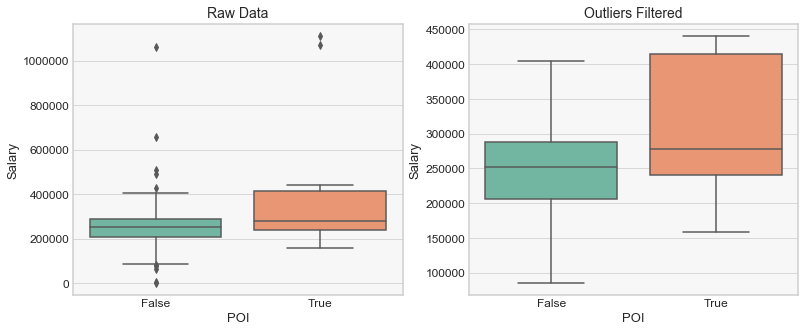

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(13,5))
ax1 = sns.boxplot(x="poi", y="salary", data=df_train, ax=axs[0])
ax2 = sns.boxplot(x="poi", y="salary", data=df_train, showfliers=False, ax=axs[1])
ax1.set_title("Raw Data"); ax1.set_xlabel("POI"); ax1.set_ylabel("Salary");
ax2.set_title("Outliers Filtered"); ax2.set_xlabel("POI"); ax2.set_ylabel("Salary");

With the "TOTAL" outlier removed, the barplot still present some ouliers. However, they are not so distant from the median values. Anyways, let's check them.

In [22]:
df_train.sort_values(by="salary", ascending=False).head(7)[["salary", "poi"]]

,salary,poi
SKILLING JEFFREY K,1111258.0,True
LAY KENNETH L,1072321.0,True
FREVERT MARK A,1060932.0,False
PICKERING MARK R,655037.0,False
WHALLEY LAWRENCE G,510364.0,False
DERRICK JR. JAMES V,492375.0,False
FASTOW ANDREW S,440698.0,True


Among the seven biggest salaries at Enrom, three belong to POIs. For instance, Jeffrey Skilling has the biggest salary. Given that the main goal of this script is to develop a classification model for the POI feature, it is reasonable to maintain these observations in the train dataframe.

Visually it is possible to notice that generally POIs have higher salaries than non POIs. Nevertheless, there are also some non POIs among the outliers. Mark Frevert is an example. 

#### POI and Total Payments

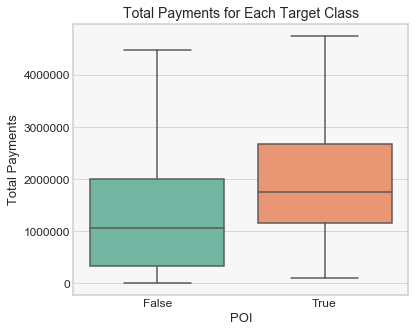

In [23]:
plt.figure(figsize=(6,5))
ax = sns.boxplot(x="poi", y="total_payments", data=df_train, showfliers=False)
ax.set_title("Total Payments for Each Target Class")
ax.set_xlabel("POI")
ax.set_ylabel("Total Payments");

Let's check the outliers.

In [24]:
df_train.sort_values(by="total_payments", ascending=False).head(7)[["total_payments", "poi"]]

,total_payments,poi
LAY KENNETH L,103559793.0,True
FREVERT MARK A,17252530.0,False
BHATNAGAR SANJAY,15456290.0,False
LAVORATO JOHN J,10425757.0,False
SKILLING JEFFREY K,8682716.0,True
MARTIN AMANDA K,8407016.0,False
BAXTER JOHN C,5634343.0,False


Likewise the "salary" feature, the "total_payments" feature tends to be higher for POIs, but some non POIs are in the outliers.

#### POI and Bonus

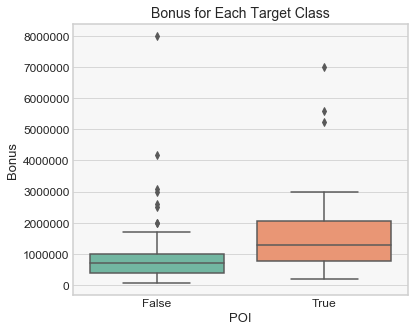

In [25]:
plt.figure(figsize=(6,5))
ax = sns.boxplot(x="poi", y="bonus", data=df_train)
ax.set_title("Bonus for Each Target Class")
ax.set_xlabel("POI")
ax.set_ylabel("Bonus");

Let's check the outliers.

In [26]:
df_train.sort_values(by="bonus", ascending=False).head(7)[["bonus", "poi"]]

,bonus,poi
LAVORATO JOHN J,8000000.0,False
LAY KENNETH L,7000000.0,True
SKILLING JEFFREY K,5600000.0,True
BELDEN TIMOTHY N,5249999.0,True
ALLEN PHILLIP K,4175000.0,False
KITCHEN LOUISE,3100000.0,False
DELAINEY DAVID W,3000000.0,True


This time, the person with the largest bonus is not a POI, but 4 out 7 biggest bonuses are from POIs. In addition, POIs generally have larger bonuses.

#### POI and Total Stock Value

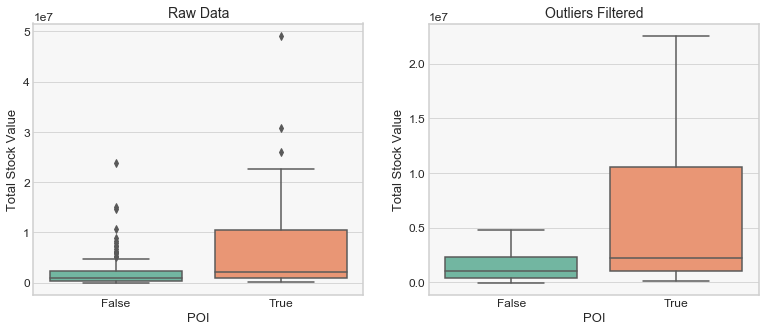

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(13,5))
ax1 = sns.boxplot(x="poi", y="total_stock_value", data=df_train, ax=axs[0])
ax2 = sns.boxplot(x="poi", y="total_stock_value", data=df_train, showfliers=False, ax=axs[1])
ax1.set_title("Raw Data"); ax1.set_xlabel("POI"); ax1.set_ylabel("Total Stock Value");
ax2.set_title("Outliers Filtered"); ax2.set_xlabel("POI"); ax2.set_ylabel("Total Stock Value");

Let's check the outliers.

In [28]:
df_train.sort_values(by="total_stock_value", ascending=False).head(7)[["total_stock_value", "poi"]]

,total_stock_value,poi
LAY KENNETH L,49110078.0,True
HIRKO JOSEPH,30766064.0,True
SKILLING JEFFREY K,26093672.0,True
PAI LOU L,23817930.0,False
RICE KENNETH D,22542539.0,True
WHITE JR THOMAS E,15144123.0,False
FREVERT MARK A,14622185.0,False


Once again the POIs present higher "total_stock_value". This means, that these four financial features previously visualized probably will be a efficient way of detecting POIs. However, it should be considered that earning a lot of money not necessarily makes a person a POI.

### E-mail Features Bivariate Analysis

#### POI and Number of E-mails From this Person to POI

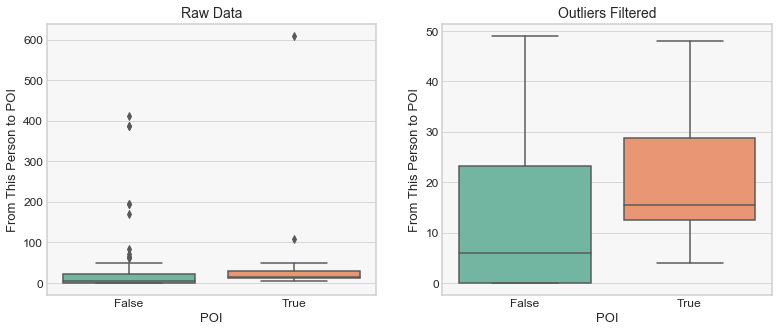

In [29]:
var = "from_this_person_to_poi"
fig, axs = plt.subplots(ncols=2, figsize=(13,5))
ax1 = sns.boxplot(x="poi", y=var, data=df_train, ax=axs[0])
ax2 = sns.boxplot(x="poi", y=var, data=df_train, showfliers=False, ax=axs[1])
ax1.set_title("Raw Data"); ax1.set_xlabel("POI"); ax1.set_ylabel("From This Person to POI");
ax2.set_title("Outliers Filtered"); ax2.set_xlabel("POI"); ax2.set_ylabel("From This Person to POI");

Let's check the outliers.

In [30]:
df_train.sort_values(by=var, ascending=False).head(7)[[var, "poi"]]

,from_this_person_to_poi,poi
DELAINEY DAVID W,609.0,True
LAVORATO JOHN J,411.0,False
KEAN STEVEN J,387.0,False
BECK SALLY W,386.0,False
MCCONNELL MICHAEL S,194.0,False
KITCHEN LOUISE,194.0,False
KAMINSKI WINCENTY J,171.0,False


As the boxplots above illustrate, POIs tend to send more e-mails to other POIs. However, as the outliers table show, some non POIs also communicate frequently via e-mails with POIs.

#### POI and Number of E-mails From POI to This Person

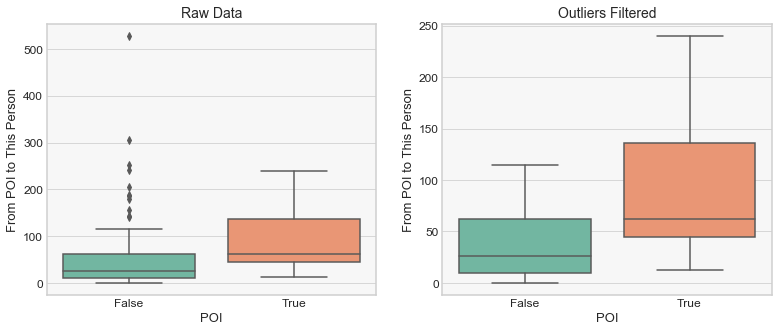

In [31]:
var = "from_poi_to_this_person"
fig, axs = plt.subplots(ncols=2, figsize=(13,5))
ax1 = sns.boxplot(x="poi", y=var, data=df_train, ax=axs[0])
ax2 = sns.boxplot(x="poi", y=var, data=df_train, showfliers=False, ax=axs[1])
ax1.set_title("Raw Data"); ax1.set_xlabel("POI"); ax1.set_ylabel("From POI to This Person");
ax2.set_title("Outliers Filtered"); ax2.set_xlabel("POI"); ax2.set_ylabel("From POI to This Person");

In [32]:
df_train.sort_values(by=var, ascending=False).head(7)[[var, "poi"]]

,from_poi_to_this_person,poi
LAVORATO JOHN J,528.0,False
DIETRICH JANET R,305.0,False
KITCHEN LOUISE,251.0,False
FREVERT MARK A,242.0,False
COLWELL WESLEY,240.0,True
BELDEN TIMOTHY N,228.0,True
REDMOND BRIAN L,204.0,False


The "from_poi_to_this_person" feature shows a similar behaviour with "from_this_person_to_poi" feature, meaning that POIs receive more e-mails from other POIs than non POIs receive. Nevertheless, we also see some non POIs among the outliers.

#### POI and Number of E-mail Sent

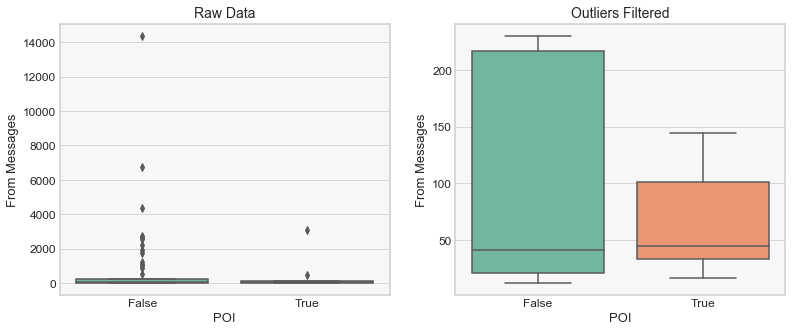

In [33]:
var = "from_messages"
fig, axs = plt.subplots(ncols=2, figsize=(13,5))
ax1 = sns.boxplot(x="poi", y=var, data=df_train, ax=axs[0])
ax2 = sns.boxplot(x="poi", y=var, data=df_train, showfliers=False, ax=axs[1])
ax1.set_title("Raw Data"); ax1.set_xlabel("POI"); ax1.set_ylabel("From Messages");
ax2.set_title("Outliers Filtered"); ax2.set_xlabel("POI"); ax2.set_ylabel("From Messages");

Let's check the outliers.

In [34]:
df_train.sort_values(by=var, ascending=False).head(7)[[var, "poi"]]

,from_messages,poi
KAMINSKI WINCENTY J,14368.0,False
KEAN STEVEN J,6759.0,False
BECK SALLY W,4343.0,False
DELAINEY DAVID W,3069.0,True
MCCONNELL MICHAEL S,2742.0,False
SHANKMAN JEFFREY A,2681.0,False
LAVORATO JOHN J,2585.0,False


It is not possible to detect a strong pattern in the boxplots, only that Wincenty Kaminski seems to like sending e-mails. He is way ahead of the second most e-mail sender, Steven Kean.

#### POI and Number of E-mails Receipt

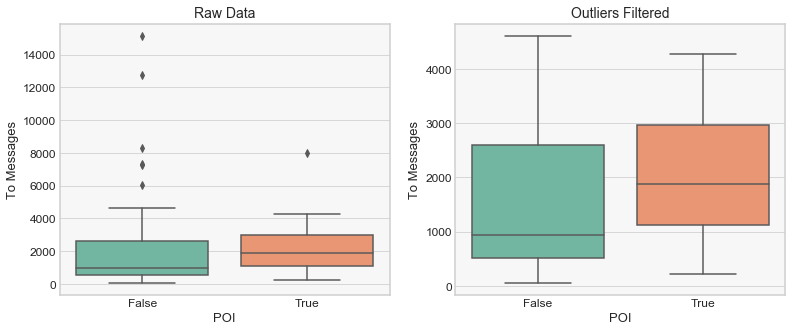

In [35]:
var = "to_messages"
fig, axs = plt.subplots(ncols=2, figsize=(13,5))
ax1 = sns.boxplot(x="poi", y=var, data=df_train, ax=axs[0])
ax2 = sns.boxplot(x="poi", y=var, data=df_train, showfliers=False, ax=axs[1])
ax1.set_title("Raw Data"); ax1.set_xlabel("POI"); ax1.set_ylabel("To Messages");
ax2.set_title("Outliers Filtered"); ax2.set_xlabel("POI"); ax2.set_ylabel("To Messages");

Let's check the outliers.

In [36]:
df_train.sort_values(by=var, ascending=False).head(7)[[var, "poi"]]

,to_messages,poi
SHAPIRO RICHARD S,15149.0,False
KEAN STEVEN J,12754.0,False
KITCHEN LOUISE,8305.0,False
BELDEN TIMOTHY N,7991.0,True
BECK SALLY W,7315.0,False
LAVORATO JOHN J,7259.0,False
WHALLEY LAWRENCE G,6019.0,False


#### POI and Number of E-mails Receipt Shared with POIs

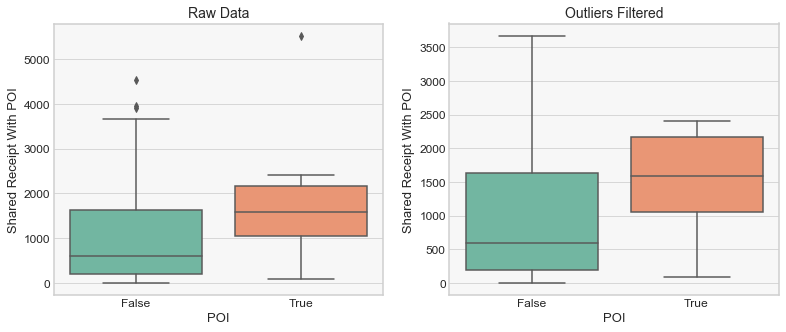

In [37]:
var = "shared_receipt_with_poi"
fig, axs = plt.subplots(ncols=2, figsize=(13,5))
ax1 = sns.boxplot(x="poi", y=var, data=df_train, ax=axs[0])
ax2 = sns.boxplot(x="poi", y=var, data=df_train, showfliers=False, ax=axs[1])
ax1.set_title("Raw Data"); ax1.set_xlabel("POI"); ax1.set_ylabel("Shared Receipt With POI");
ax2.set_title("Outliers Filtered"); ax2.set_xlabel("POI"); ax2.set_ylabel("Shared Receipt With POI");

### Feature Engineering

#### Ratio Number of E-mails Receipt from POIs to Number of E-mails Receipt

The features "from_poi_to_this_person" and "to_messages" can be related through a new feature "ratio_receipt_messages" measuring the ratio between them.

In [38]:
df_train["ratio_receipt_messages"] = df_train["from_poi_to_this_person"]/df_train["to_messages"]

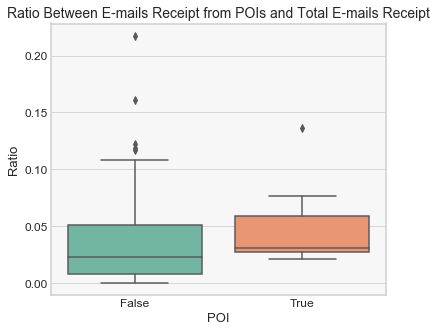

In [39]:
plt.figure(figsize=(6,5))
var = "ratio_receipt_messages"
ax = sns.boxplot(x="poi", y=var, data=df_train)
ax.set_title("Ratio Between E-mails Receipt from POIs and Total E-mails Receipt")
ax.set_xlabel("POI")
ax.set_ylabel("Ratio");

#### Ratio Number of E-mails Sent to POIs to Number of E-mails Sent

In [40]:
df_train["ratio_sent_messages"] = df_train["from_this_person_to_poi"]/df_train["from_messages"]

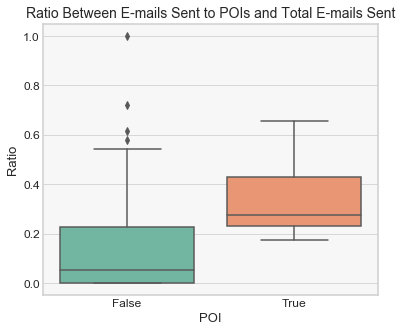

In [41]:
plt.figure(figsize=(6,5))
var = "ratio_sent_messages"
ax = sns.boxplot(x="poi", y=var, data=df_train)
ax.set_title("Ratio Between E-mails Sent to POIs and Total E-mails Sent")
ax.set_xlabel("POI")
ax.set_ylabel("Ratio");

#### Ratio Number of E-mails Shared Receipt with POIs to Number of E-mails Receipt

In [42]:
df_train["ratio_shared_receipt"] = df_train["shared_receipt_with_poi"]/df_train["to_messages"]

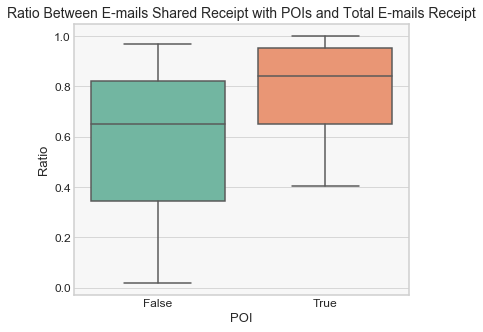

In [43]:
plt.figure(figsize=(6,5))
var = "ratio_shared_receipt"
ax = sns.boxplot(x="poi", y=var, data=df_train)
ax.set_title("Ratio Between E-mails Shared Receipt with POIs and Total E-mails Receipt")
ax.set_xlabel("POI")
ax.set_ylabel("Ratio");

#### Cleaning NaN

After the Feature Engineering, some observations now may have NaN caused by division by zero. This way, let's make a new NaN cleaning anything else.

In [44]:
# Replace NaN by 0.
df_train = df_train.fillna(0)
df_train.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,deferred_income,long_term_incentive,from_poi_to_this_person,ratio_receipt_messages,ratio_sent_messages,ratio_shared_receipt
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,2195.0,152.0,65.0,False,-3081055.0,304805.0,47.0,0.016196,0.029613,0.484838
BADUM JAMES P,0.0,0.0,178980.0,182466.0,257817.0,0.0,0.0,0.0,0.0,257817.0,...,0.0,0.0,0.0,False,0.0,0.0,0.0,0.000000,0.000000,0.000000
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,29.0,864523.0,0.0,False,-5104.0,0.0,39.0,0.068905,0.000000,0.821555
BAXTER JOHN C,267102.0,0.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,0.0,0.0,10623258.0,...,0.0,2660303.0,0.0,False,-1386055.0,1586055.0,0.0,0.000000,0.000000,0.000000
BAY FRANKLIN R,239671.0,0.0,260455.0,827696.0,0.0,400000.0,145796.0,0.0,-82782.0,63014.0,...,0.0,69.0,0.0,False,-201641.0,0.0,0.0,0.000000,0.000000,0.000000


### Correlation Matrix

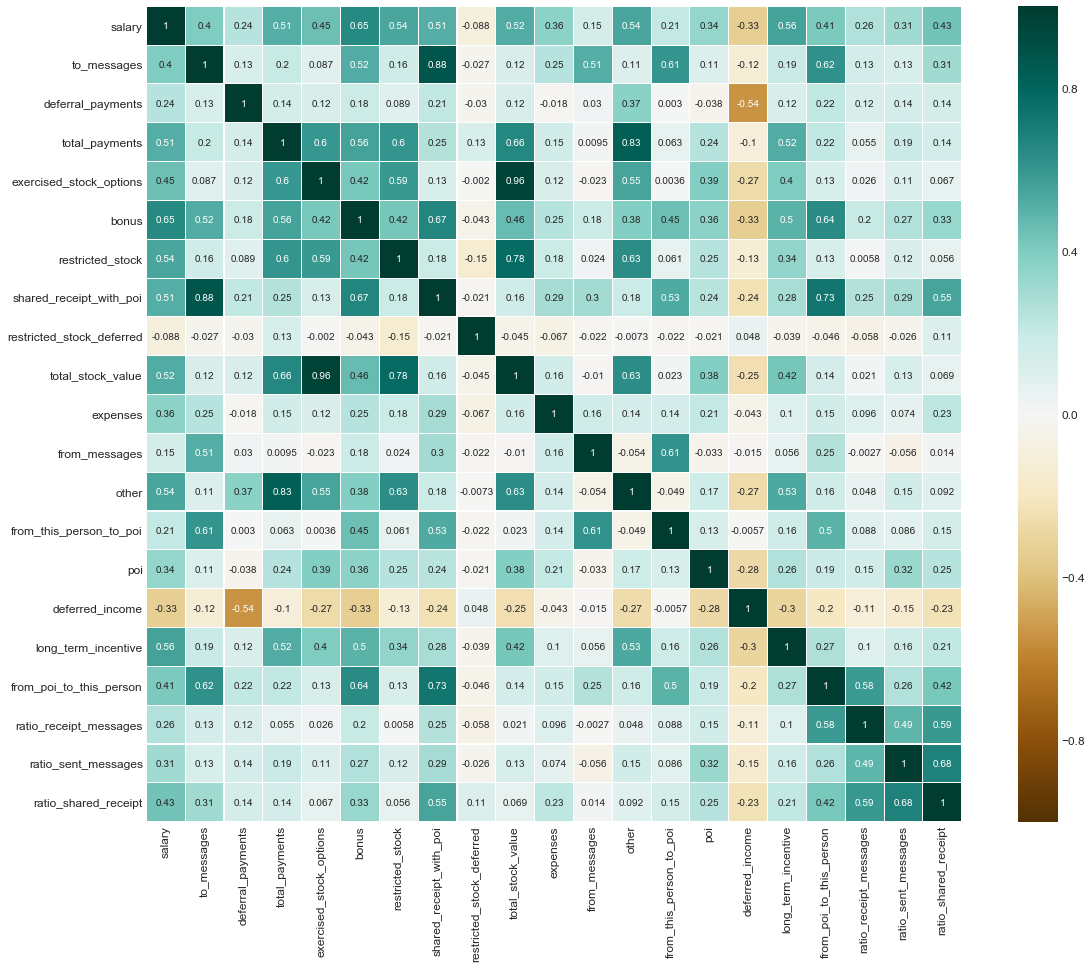

In [45]:
corrmat = df_train.corr()
plt.figure(figsize=(20,15))
ax = sns.heatmap(corrmat, linewidths=0.1,vmax=1, vmin=-1, square=True, linecolor='white', annot=True, cmap=plt.cm.BrBG)

### Benchmarck Classification Model

As a initial Classifcation Model, let's use a Decision Tree Classifier.

Through the correlation matrix we see that the features "restricted_stock_deferred" and "total_stock_value" have strong linear correlation with "total_payments" and "exercised_stock_options" respectively. Thus, let's remove them so our input space dimensionality can be reduced without loosing many information so our Decision Tree Classifier can perform better.

In [46]:
df_train.shape

(145, 21)

In [47]:
df_train_tree = df_train.drop(["restricted_stock_deferred", "total_stock_value"], axis=1)
df_train_tree.shape

(145, 19)

Defining and training the estimator.

In [48]:
estimators = [("scale", MinMaxScaler()), ("clf", tree.DecisionTreeClassifier(random_state=42))]
clf = Pipeline(estimators)

Since it is a benchmack model, let's use all features in order to train our model.

In [49]:
# Create Features list with "poi" in the first position.
features_tree = df_train_tree.columns.values.tolist()
features_tree.insert(0, features_tree.pop(features_tree.index("poi")))

In [50]:
features_tree

['poi',
 'salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'expenses',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person',
 'ratio_receipt_messages',
 'ratio_sent_messages',
 'ratio_shared_receipt']

Now, let's dump the estimators, features list and the modified dataset so we can test the classifier.

In [51]:
my_dataset_tree = df_train_tree.to_dict(orient="index")
dump_classifier_and_data(clf, my_dataset_tree, features_tree)

The validation results.

In [52]:
%%bash
python tester.py

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'))])
	Accuracy: 0.81127	Precision: 0.28166	Recall: 0.26800	F1: 0.27466	F2: 0.27063
	Total predictions: 15000	True positives:  536	False positives: 1367	False negatives: 1464	True negatives: 11633



/Users/diogocosin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


This is a fair result considering that it is our first classification model. Nevertheless, let's try to improve the resulting metrics. We will do this by eliminating the sparse features "deferral_payments" and "deferred_income".

### Reducing the Benchmarck Classifier Input Space Dimensionality

The "deferral_payments" and the "deferred_income" are also highly sparsed features with less than 40% of the observations possessing them. Thus, let's drop them so we are able to reduce the input space dimensionality easing the Machine Learning models computation.

In [53]:
df_train_tree = df_train_tree.drop(["deferral_payments", "deferred_income"], axis=1)
df_train_tree.shape

(145, 17)

In [54]:
# Create Features list with "poi" in the first position.
features_tree = df_train_tree.columns.values.tolist()
features_tree.insert(0, features_tree.pop(features_tree.index("poi")))

In [55]:
features_tree

['poi',
 'salary',
 'to_messages',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'expenses',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'long_term_incentive',
 'from_poi_to_this_person',
 'ratio_receipt_messages',
 'ratio_sent_messages',
 'ratio_shared_receipt']

In [57]:
my_dataset_tree = df_train_tree.to_dict(orient="index")
dump_classifier_and_data(clf, my_dataset_tree, features_tree)

In [58]:
%%bash
python tester.py

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'))])
	Accuracy: 0.81427	Precision: 0.28641	Recall: 0.26350	F1: 0.27448	F2: 0.26778
	Total predictions: 15000	True positives:  527	False positives: 1313	False negatives: 1473	True negatives: 11687



/Users/diogocosin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The results have not improved by just reducing the input space dimensionality. Let's try a different Machine Learning model.

### Linear SVC

Let's try the Linear SVC without reducing the input space.

In [59]:
estimators = [("scale", MinMaxScaler()), ("clf", LinearSVC(random_state=42))]
clf = Pipeline(estimators)

In [55]:
features = df_train.columns.values.tolist()
features.insert(0, features.pop(features.index("poi")))

In [56]:
features

['poi',
 'salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person',
 'ratio_receipt_messages',
 'ratio_sent_messages',
 'ratio_shared_receipt']

In [54]:
my_dataset = df_train.to_dict(orient="index")
dump_classifier_and_data(clf, my_dataset, features)

In [63]:
%%bash
python tester.py

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86360	Precision: 0.46788	Recall: 0.16750	F1: 0.24669	F2: 0.19218
	Total predictions: 15000	True positives:  335	False positives:  381	False negatives: 1665	True negatives: 12619



/Users/diogocosin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The Linear SVC returns a better precision result than the Decision Tree. This metric should receive extra weight when evaluating the classifacation model given that we cannot judge an innocent person as a POI.

On the other hand, the remaining metrics have been compromised. For instance, the Recall decreased from 26.35% to 16.75%. The ideal classification model should combine an excellent precision result with decent remaining metrics. Let's carry on with our jorney on trying to find the best Machine Learning model.

### Random Forest Classifier

Emsemble methods are known for returning better result than simple Trees. Let's define a Random Forest Classifier hoping to confirm this claim.

In [64]:
estimators = [("scale", MinMaxScaler()), ("clf", RandomForestClassifier(random_state=42))]
clf = Pipeline(estimators)

In [65]:
dump_classifier_and_data(clf, my_dataset, features)

In [66]:
features_tree

['poi',
 'salary',
 'to_messages',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'expenses',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'long_term_incentive',
 'from_poi_to_this_person',
 'ratio_receipt_messages',
 'ratio_sent_messages',
 'ratio_shared_receipt']

In [67]:
%%bash
python tester.py

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])
	Accuracy: 0.85880	Precision: 0.40723	Recall: 0.12950	F1: 0.19651	F2: 0.14995
	Total predictions: 15000	True positives:  259	False positives:  377	False negatives: 1741	True negatives: 12623



/Users/diogocosin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Indeed the Random Forest Classifier obtained better precision than the Decision Tree and better Recall, F1 and F2 than the Linear SVC.

### Optimizing and Trying New Models with GridSearchCV

Now that we have gotten our benchmarck models, let's try to otmize the hyperparameters using Grid Searching. Also, let's define other models and analyze how they compare with the previous ones.

#### Decision Tree

In [69]:
# Defining the Pipeline
estimators = [
    ("normalize", MinMaxScaler()), 
    ("reduce_dim", PCA(random_state=42)), 
    ("clf", tree.DecisionTreeClassifier(random_state=42))
]
pipe = Pipeline(estimators)

# Defining the Search Grid
param_grid = dict(reduce_dim=[None, PCA(1), PCA(2), PCA(5), PCA(10), PCA(15)],
                  clf__max_depth=[None, 1, 5, 10, 100],
                  clf__min_samples_split=[2, 10, 50, 100],
                  clf__min_samples_leaf=[1, 10, 50, 100],
                  clf__min_impurity_split=[0.0, 0.5, 5.0, 10.0, 50.0, 100.0])
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring="f1")

# Splitting the train data between features and target
df_features  = df_train_tree.drop("poi", axis=1)
df_labels = df_train_tree["poi"]

# Fitting the model
grid_search.fit(df_features, df_labels)

# Assigning the best estimator
clf = grid_search.best_estimator_

Let's see the parameters defined for the best estimator.

In [70]:
clf.get_params()

{'clf': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None, min_impurity_split=0.0,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=42,
             splitter='best'),
 'clf__class_weight': None,
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': None,
 'clf__max_leaf_nodes': None,
 'clf__min_impurity_split': 0.0,
 'clf__min_samples_leaf': 10,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__presort': False,
 'clf__random_state': 42,
 'clf__splitter': 'best',
 'normalize': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'normalize__copy': True,
 'normalize__feature_range': (0, 1),
 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'reduce_dim__copy': True,
 'reduce_dim__iterated_power': 'auto',
 'reduce

In [71]:
dump_classifier_and_data(clf, my_dataset_tree, features_tree)

In [72]:
%%bash
python tester.py

Pipeline(steps=[('normalize', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            m...        min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])
	Accuracy: 0.86300	Precision: 0.48404	Recall: 0.41700	F1: 0.44803	F2: 0.42888
	Total predictions: 15000	True positives:  834	False positives:  889	False negatives: 1166	True negatives: 12111



/Users/diogocosin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The Grid Search helped us to reach a very decent Decision Tree model. Now, all metrics are above 40%, including the precision with 48.4%.

#### Linear SVC

Continuing with the optmization, let's Grid Search the Linear SVC model.

In [182]:
# Defining the Pipeline
estimators = [
    ("normalize", MinMaxScaler()), 
    ("reduce_dim", PCA(random_state=42)), 
    ("clf", LinearSVC(dual=False, random_state=42))]
pipe = Pipeline(estimators)

# Defining the Search Grid
param_grid = dict(reduce_dim=[None, PCA(1), PCA(2), PCA(5), PCA(10)],
                  clf__penalty=["l1", "l2"],
                  clf__C=[0.1, 1, 10, 100, 1000],
                  clf__class_weight=[None, "balanced"])
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring="f1")

# Fitting the model
grid_search.fit(df_features, df_labels)

# Splitting the train data between features and target
df_features  = df_train.drop("poi", axis=1)
df_labels = df_train["poi"]

# Assigning the best estimator
clf = grid_search.best_estimator_

In [225]:
clf.get_params()

{'clf': RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=5, max_features='auto',
             max_leaf_nodes=None, min_impurity_split=0.0,
             min_samples_leaf=4, min_samples_split=66,
             min_weight_fraction_leaf=0.0, n_estimators=84, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 'clf__bootstrap': True,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'gini',
 'clf__max_depth': 5,
 'clf__max_features': 'auto',
 'clf__max_leaf_nodes': None,
 'clf__min_impurity_split': 0.0,
 'clf__min_samples_leaf': 4,
 'clf__min_samples_split': 66,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 84,
 'clf__n_jobs': 1,
 'clf__oob_score': False,
 'clf__random_state': 42,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'normalize': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'normalize__copy': True,
 'normalize__feature_range': (0, 1),
 'reduce_dim': PCA(copy=True, itera

In [224]:
best_params = clf.get_params()

In [184]:
dump_classifier_and_data(clf, my_dataset, features)

In [185]:
%%bash
python tester.py

Pipeline(steps=[('normalize', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce_dim', None), ('clf', LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=42, tol=0.0001,
     verbose=0))])
	Accuracy: 0.82447	Precision: 0.39572	Recall: 0.60050	F1: 0.47706	F2: 0.54418
	Total predictions: 15000	True positives: 1201	False positives: 1834	False negatives:  799	True negatives: 11166



/Users/diogocosin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The metrics Recall, F1 and F2 have increased after the Grid Search, however the precision decreased to 39.57%. 

#### Random Forest

Given that applying a Grid Search to a Random Forest is computationally costly, let's use an alternative solution with Randomized Search.

In [246]:
# Defining the estimator
estimators = [
    ("normalize", MinMaxScaler()), 
    ("reduce_dim", PCA(random_state=42)), 
    ("clf", RandomForestClassifier(random_state=42))]
pipe = Pipeline(estimators)

# Defining the Random Search
param_distr = dict(reduce_dim=[None, PCA(1), PCA(5), PCA(10)],
                  clf__n_estimators=sp_randint(5,100),
                  clf__bootstrap= [True, False],
                  clf__class_weight=[None, "balanced"],
                  clf__max_depth=[None, 1, 5, 10, 100],
                  clf__min_samples_split=sp_randint(2, 100),
                  clf__min_samples_leaf=sp_randint(1, 100),
                  clf__min_impurity_split=[0.0, 0.5, 5.0, 10.0, 50.0, 100.0])

cv = StratifiedShuffleSplit(random_state=42, n_splits=3)
random_search = RandomizedSearchCV(pipe, cv=cv, param_distributions=param_distr, scoring="f1", n_jobs=-1, n_iter=2000)

# Splitting the train data between features and target
df_features  = df_train_tree.drop("poi", axis=1)
df_labels = df_train_tree["poi"]

# Fitting the model
random_search.fit(df_features, df_labels)

# Assigning the best estimator
clf = random_search.best_estimator_

The best estimator parameters.

In [247]:
clf.get_params()

{'clf': RandomForestClassifier(bootstrap=False, class_weight='balanced',
             criterion='gini', max_depth=100, max_features='auto',
             max_leaf_nodes=None, min_impurity_split=0.0,
             min_samples_leaf=7, min_samples_split=27,
             min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 'clf__bootstrap': False,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'gini',
 'clf__max_depth': 100,
 'clf__max_features': 'auto',
 'clf__max_leaf_nodes': None,
 'clf__min_impurity_split': 0.0,
 'clf__min_samples_leaf': 7,
 'clf__min_samples_split': 27,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 80,
 'clf__n_jobs': 1,
 'clf__oob_score': False,
 'clf__random_state': 42,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'normalize': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'normalize__copy': True,
 'normalize__feature_range': (0, 1),
 'reduce_dim': None,
 'steps'

In [226]:
best_params = clf.get_params()

In [248]:
dump_classifier_and_data(clf, my_dataset_tree, features_tree)

In [249]:
%%bash
python tester.py

Pipeline(steps=[('normalize', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce_dim', None), ('clf', RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=0.0,
            min_samples_leaf=7, min_samples_split=27,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])
	Accuracy: 0.84900	Precision: 0.45461	Recall: 0.66350	F1: 0.53954	F2: 0.60766
	Total predictions: 15000	True positives: 1327	False positives: 1592	False negatives:  673	True negatives: 11408



/Users/diogocosin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### SVC

In [65]:
# Defining the estimator
estimators = [
    ("normalize", MinMaxScaler()), 
    ("reduce_dim", PCA(random_state=42)), 
    ("clf", SVC(random_state=42, cache_size=2000))
]
pipe = Pipeline(estimators)

# Defining the Randomized Search
param_distr = dict(reduce_dim=[None, PCA(1), PCA(5), PCA(10)],
                  clf__class_weight=[None, "balanced"],
                  clf__C=expon(),
                  clf__kernel=["linear", "poly", "rbf", "sigmoid"],
                  clf__gamma=expon(),
                  clf__coef0=expon())

cv = StratifiedShuffleSplit(random_state=42, n_splits=3)
random_search = RandomizedSearchCV(pipe, param_distributions=param_distr, scoring="f1", n_jobs=-1, n_iter=500, cv=cv)
                   
# Splitting the train data between features and target
df_features  = df_train.drop("poi", axis=1)
df_labels = df_train["poi"]

# Fitting the model
random_search.fit(df_features, df_labels)

# Assigning the best estimator
clf = random_search.best_estimator_

In [66]:
clf.get_params()

{'clf': SVC(C=0.1723584105260911, cache_size=2000, class_weight='balanced',
   coef0=0.25903237165967224, decision_function_shape=None, degree=3,
   gamma=0.9323003632779977, kernel='poly', max_iter=-1, probability=False,
   random_state=42, shrinking=True, tol=0.001, verbose=False),
 'clf__C': 0.1723584105260911,
 'clf__cache_size': 2000,
 'clf__class_weight': 'balanced',
 'clf__coef0': 0.25903237165967224,
 'clf__decision_function_shape': None,
 'clf__degree': 3,
 'clf__gamma': 0.9323003632779977,
 'clf__kernel': 'poly',
 'clf__max_iter': -1,
 'clf__probability': False,
 'clf__random_state': 42,
 'clf__shrinking': True,
 'clf__tol': 0.001,
 'clf__verbose': False,
 'normalize': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'normalize__copy': True,
 'normalize__feature_range': (0, 1),
 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'reduce_dim__copy': True,
 'reduce_dim__iterated_power': 'auto',
 '

In [67]:
dump_classifier_and_data(clf, my_dataset, features)

In [68]:
%%bash
python tester.py

Pipeline(steps=[('normalize', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=0.1723584105260911, cache_size=2000, class_weight='balanced',
  coef0=0.25903237165967224, decision_function_shape=None, degree=3,
  gamma=0.9323003632779977, kernel='poly', max_iter=-1, probability=False,
  random_state=42, shrinking=True, tol=0.001, verbose=False))])
	Accuracy: 0.87107	Precision: 0.51416	Recall: 0.59900	F1: 0.55335	F2: 0.57986
	Total predictions: 15000	True positives: 1198	False positives: 1132	False negatives:  802	True negatives: 11868



/Users/diogocosin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


It's a good result, however by tweaking the hyperparameters we can still obtain a better precision result.

In [78]:
estimators = [
    ("normalize", MinMaxScaler()), 
    ("clf", SVC(random_state=42, C=10, gamma=0.5, kernel="sigmoid"))
]
clf = Pipeline(estimators)

In [79]:
dump_classifier_and_data(clf, my_dataset, features)

In [80]:
%%bash
python tester.py

Pipeline(steps=[('normalize', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.5, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.88773	Precision: 0.79699	Recall: 0.21200	F1: 0.33491	F2: 0.24848
	Total predictions: 15000	True positives:  424	False positives:  108	False negatives: 1576	True negatives: 12892



/Users/diogocosin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
